# Cold clim over the High Mountain of Asia (HMA) in CMIP6

## Import of modules / packages
- [intake](https://intake-esm.readthedocs.io/en/latest/): to access the data 
- [xarray](http://xarray.pydata.org/en/stable/) : to manipulate the data
- [proplot](https://proplot.readthedocs.io/en/latest/) : to make plots
- [xesmf](https://xesmf.readthedocs.io/en/latest/) : to make regrid (works only for **Linux** and **Mac**)
- [dask](https://dask.org/) to do parallelization

In [1]:
import intake 
import xarray as xr
import proplot as plot
import xesmf as xe
import numpy as np

In [2]:
# Optional for parallelization (if you have installed dask)

from dask.distributed import Client
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44227 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.33 GB


In [3]:
# HMA domain

lonlim = slice(50,120)
latlim = slice(0,60)

## CMIP6 data via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
This is possible thanks to the [Pangeo](https://pangeo.io/) project and the [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets)! (still quite experimental)

Otherwise you have to download the data from https://esgf-node.llnl.gov/search/cmip6/ (official international database, but this is much more tedious).

In [13]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

cat = col.search(
    experiment_id=["historical"],
    table_id="Amon",
    variable_id="tas",
    source_id=["IPSL-CM6A-LR"],
#     member_id="r1i1p1f1"
)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,32
table_id,1
variable_id,1
grid_label,1
zstore,32
dcpp_init_year,0


In [15]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r11i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
2,CMIP,IPSL,IPSL-CM6A-LR,historical,r12i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
3,CMIP,IPSL,IPSL-CM6A-LR,historical,r13i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803
4,CMIP,IPSL,IPSL-CM6A-LR,historical,r14i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803


In [18]:
cat.keys()

['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

In [19]:
data_source = cat["CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr"]
ds = data_source(
    zarr_kwargs={"consolidated": True, "decode_times": True}
).to_dask()
ds

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, member_id: 32, time: 1980)
Coordinates:
    height       float64 ...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * member_id    (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
Dimensions without coordinates: axis_nbounds
Data variables:
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 143, 144), meta=np.ndarray>
Attributes:
    institution_id:          IPSL
    activity_id:             CMIP
    nominal_resolution:      250 km
    experiment_id:           historical
    status:                  2019-10-25;created;by nhn2@columbia.edu
    experiment:              all-forcing simulation of the recent past
    source_id:               IPSL-CM6A-LR
    variant_info:            Restart from another point in piControl.. Inform...
    title:                   IPSL-CM6A-LR model output prepared for CMIP6 / C...
    table_id:                Amon
    source_type:             AOGCM BGC
    realm:                   atmos
    license:                 CMIP6 model data produced by IPSL is licensed un...
    Conventions:             CF-1.7 CMIP-6.2
    parent_mip_era:          CMIP6
    intake_esm_varname:      tas
    tracking_id:             hdl:21.14100/73b9d5f7-02af-424d-b209-bd6e9b470c1...
    parent_experiment_id:    piControl
    forcing_index:           1
    history:                 Mon Sep  3 17:43:49 2018: ncatted -O -a parent_v...
    frequency:               mon
    data_specs_version:      01.00.21
    variable_id:             tas
    sub_experiment_id:       none
    grid:                    LMDZ grid
    parent_activity_id:      CMIP
    CMIP6_CV_version:        cv=6.2.3.5-2-g63b123e
    physics_index:           1
    parent_time_units:       days since 1850-01-01 00:00:00
    sub_experiment:          none
    institution:             Institut Pierre Simon Laplace, Paris 75252, France
    description:             CMIP6 historical
    product:                 model-output
    contact:                 ipsl-cmip6@listes.ipsl.fr
    grid_label:              gr
    branch_method:           standard
    NCO:                     "4.6.0"
    parent_variant_label:    r1i1p1f1
    external_variables:      areacella
    branch_time_in_child:    0.0
    source:                  IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 14...
    parent_source_id:        IPSL-CM6A-LR
    mip_era:                 CMIP6
    EXPID:                   historical
    initialization_index:    1
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr

## Compute the climatology

In [23]:
clim = ds.sel(time=slice('1979','2014')).tas.mean('time')
clim

,Array,Chunk
Bytes,2.64 MB,82.37 kB
Shape,"(32, 143, 144)","(1, 143, 144)"
Count,578 Tasks,32 Chunks
Type,float32,numpy.ndarray


In [26]:
clim.load()

<xarray.DataArray 'tas' (member_id: 32, lat: 143, lon: 144)>
array([[[221.88605, 221.88605, 221.88605, ..., 221.88605, 221.88605,
         221.88605],
        [225.20335, 225.09045, 224.99779, ..., 225.41623, 225.3257 ,
         225.29181],
        [225.62743, 225.45068, 225.26662, ..., 226.1258 , 225.98047,
         225.8036 ],
        ...,
        [259.32437, 259.40335, 259.45364, ..., 259.13608, 259.23087,
         259.2881 ],
        [259.23593, 259.26987, 259.29498, ..., 259.16565, 259.17142,
         259.18277],
        [258.56714, 258.56714, 258.56714, ..., 258.56714, 258.56714,
         258.56714]],

       [[221.70576, 221.70576, 221.70576, ..., 221.70576, 221.70576,
         221.70576],
        [225.0025 , 224.89719, 224.7954 , ..., 225.23994, 225.12883,
         225.11241],
        [225.46213, 225.27174, 225.10641, ..., 225.94705, 225.81517,
         225.6275 ],
...
        [257.97757, 258.04053, 258.07635, ..., 257.83093, 257.9065 ,
         257.95502],
        [257.83725, 257.86023, 257.87888, ..., 257.78284, 257.7889 ,
         257.79532],
        [256.91666, 256.91666, 256.91666, ..., 256.91666, 256.91666,
         256.91666]],

       [[221.54759, 221.54759, 221.54759, ..., 221.54759, 221.54759,
         221.54759],
        [224.8703 , 224.75969, 224.66136, ..., 225.09473, 225.00452,
         224.96461],
        [225.32303, 225.14645, 224.96379, ..., 225.83818, 225.67383,
         225.51459],
        ...,
        [258.28864, 258.34897, 258.38733, ..., 258.13904, 258.21677,
         258.26285],
        [258.1631 , 258.18738, 258.20605, ..., 258.1094 , 258.11374,
         258.1215 ],
        [257.31607, 257.31607, 257.31607, ..., 257.31607, 257.31607,
         257.31607]]], dtype=float32)
Coordinates:
    height     float64 2.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'

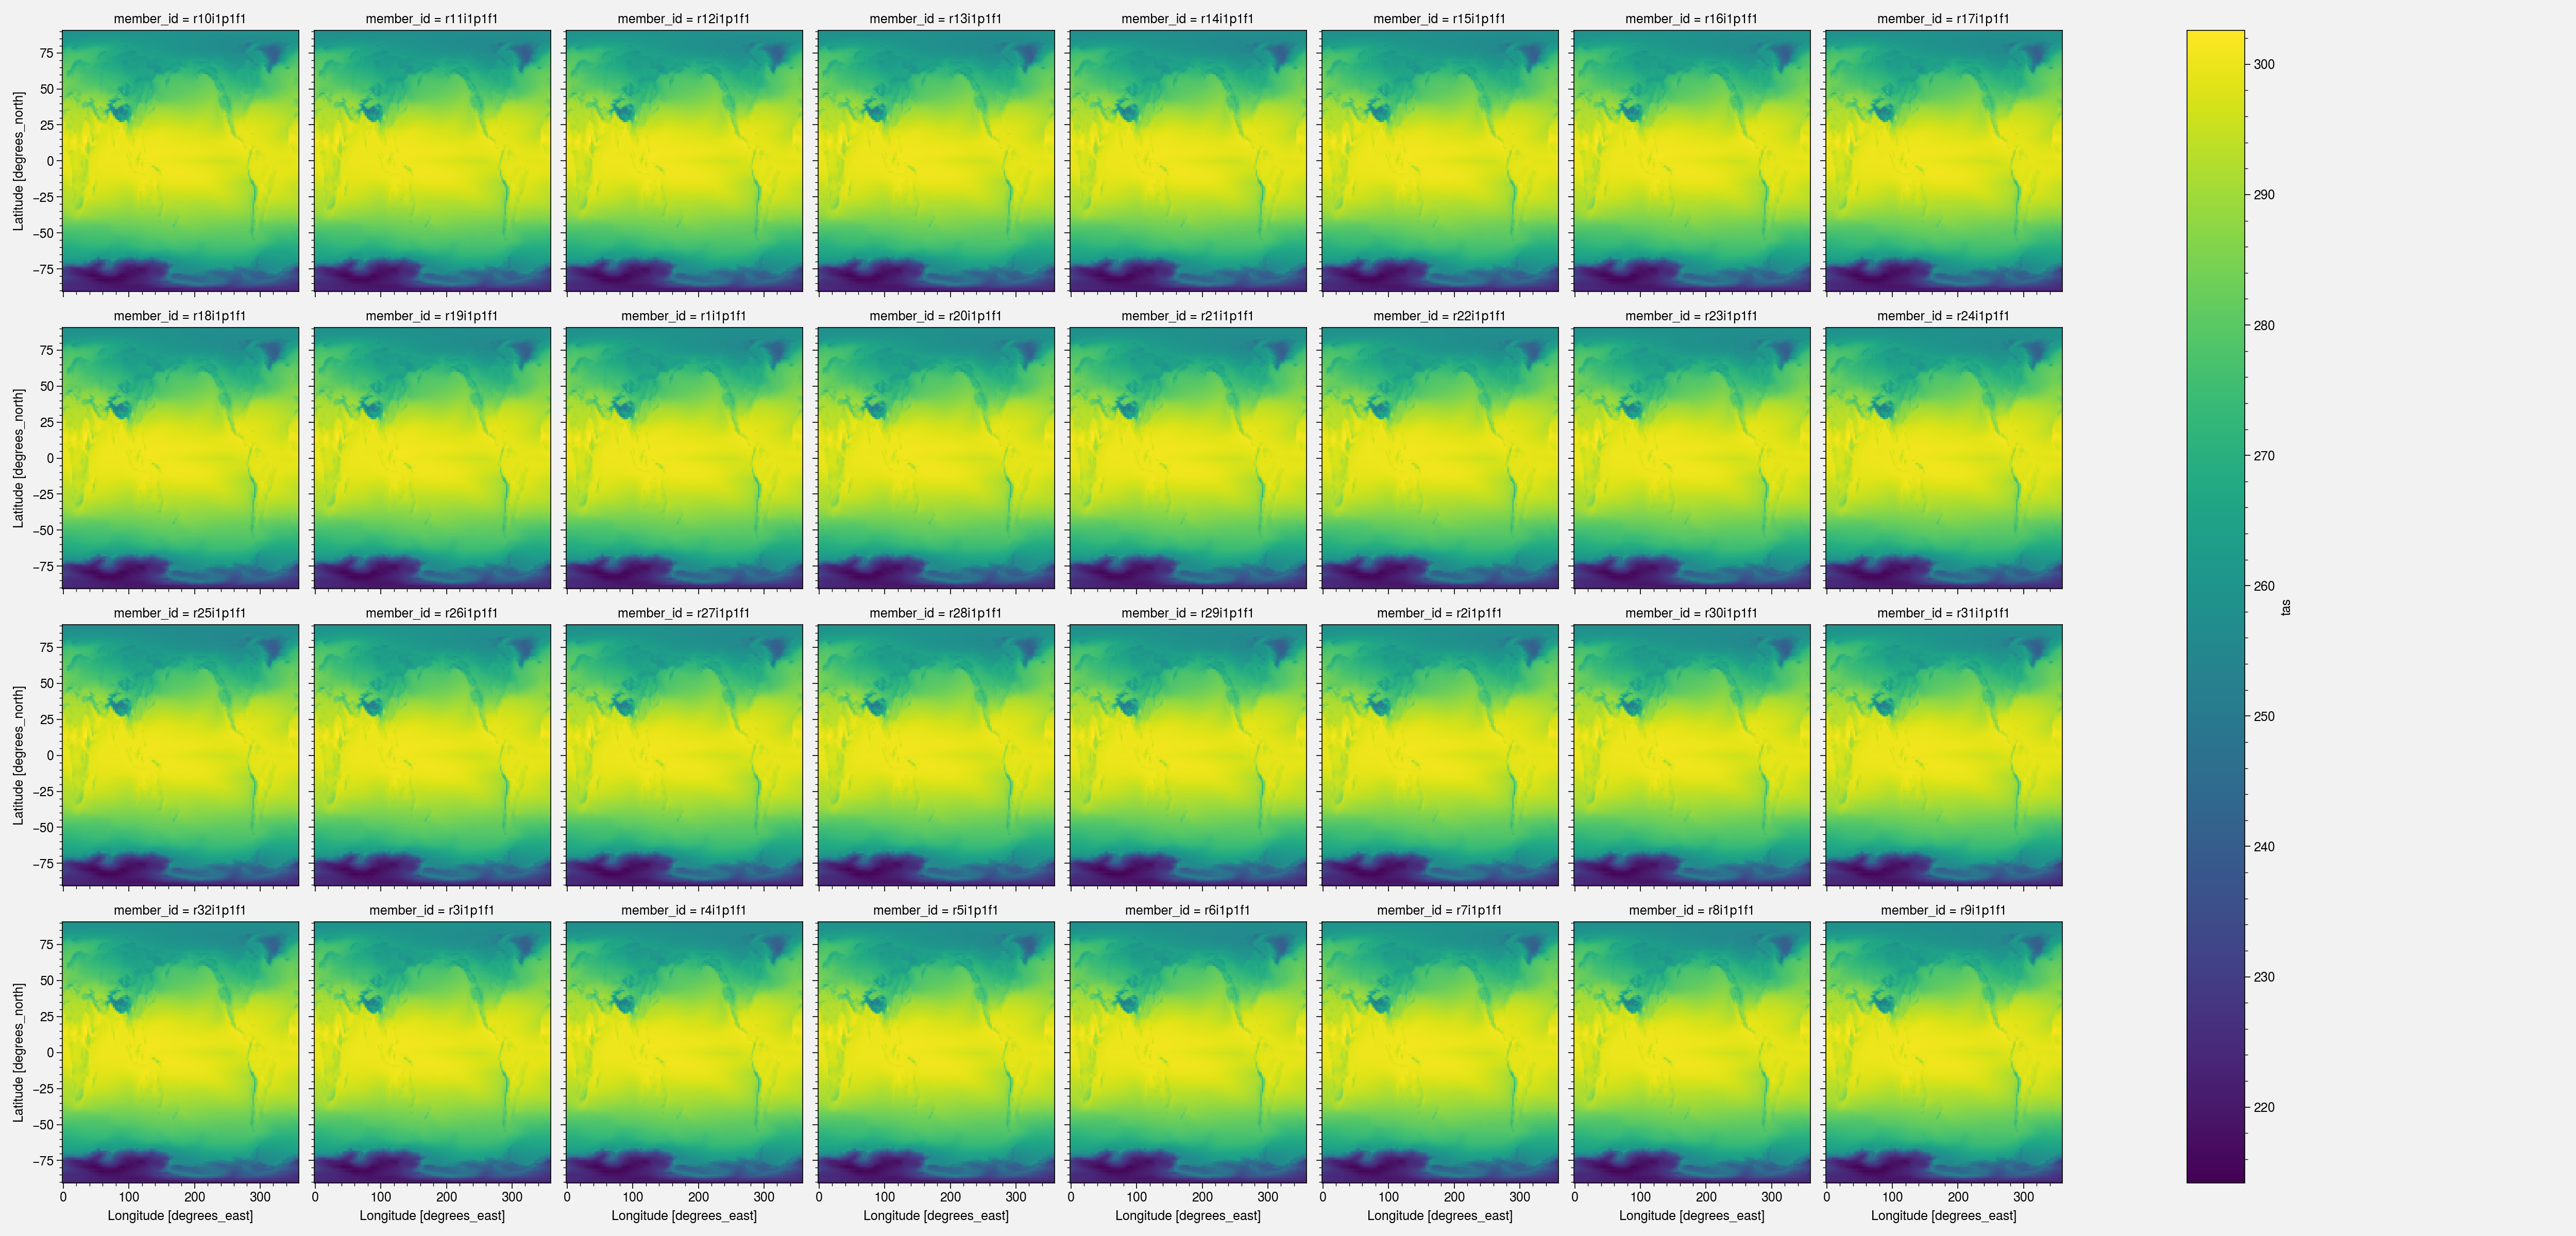

In [29]:
clim.plot(col='member_id', col_wrap=8)

## Close the Dask client

In [42]:
client.close()